In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_csv("data_banknote_authentication.txt", 
                  sep=',', 
                  names=["Variance", "Skewness", "Curtosis", "Entropy", "Class"])

In [3]:
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df=df.dropna()

<AxesSubplot:>

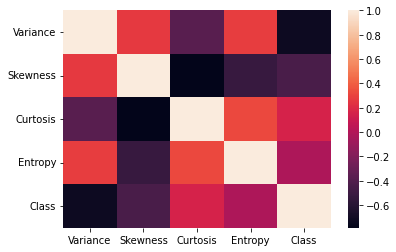

In [5]:
sns.heatmap(df.corr())

In [6]:
list = df.values.tolist()

In [7]:
def shuffle(to_shuffle):
  shuffled = []
  while len(to_shuffle)>0: 
    randomIdx = random.randint(0, len(to_shuffle)-1)
    shuffled.append(to_shuffle[randomIdx])
    del to_shuffle [randomIdx] 
  return shuffled

In [8]:
list = shuffle(list)

In [9]:
def split(list, ratio):
  train = []
  validation = []
  test = []
  for i in range(len(list)):
    if(i/len(list) < ratio[0]):
      train.append(list[:][i])
    elif (i/len(list) > ratio[0] and i/len(list) < ratio[0] + ratio[1]):
      validation.append(list[:][i])
    else:
      test.append(list[:][i])
  return train, validation, test

In [10]:
train, validation, test = split(list, [0.7,0.2])

In [11]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

In [12]:
def splitXandY(list, labelIdx):
  x = list[:,0:labelIdx]
  y = list[:,labelIdx]
  return x,y

In [13]:
X_train, y_train = splitXandY(train, 4)
X_validation, y_validation = splitXandY(validation, 4)
X_test, y_test = splitXandY(test, 4)

In [14]:
def getMinandMax(list):
  minList = []
  maxList = []
  for i in range(len(list[0])):
    col = list[:,i]
    minList.append(min(col)) 
    maxList.append(max(col))   
  return minList, maxList

In [15]:
def normalize(list, min, max):
  newList = list.copy()
  for i in range(len(list[0])):
    col = list[:,i]
    for j in range(len(col)):
      newList[j][i] = (col[j] - min[i] ) / (max[i] - min[i])
  return newList

In [16]:
min, max = getMinandMax(train)
X_train_norm = normalize(X_train, min, max)
X_validation_norm = normalize(X_validation, min, max)
X_test_norm = normalize(X_test, min, max)

In [17]:
X_train_norm

array([[0.49296526, 0.86758253, 0.06714046, 0.10285426],
       [0.54529635, 0.39654685, 0.36012368, 0.6672525 ],
       [0.44866336, 0.54426845, 0.20581619, 0.71160308],
       ...,
       [0.70790876, 0.77842005, 0.18087258, 0.7699843 ],
       [0.40769026, 0.33564877, 0.50622501, 0.79579224],
       [0.74072071, 0.81168005, 0.21058274, 0.51653845]])

<AxesSubplot:>

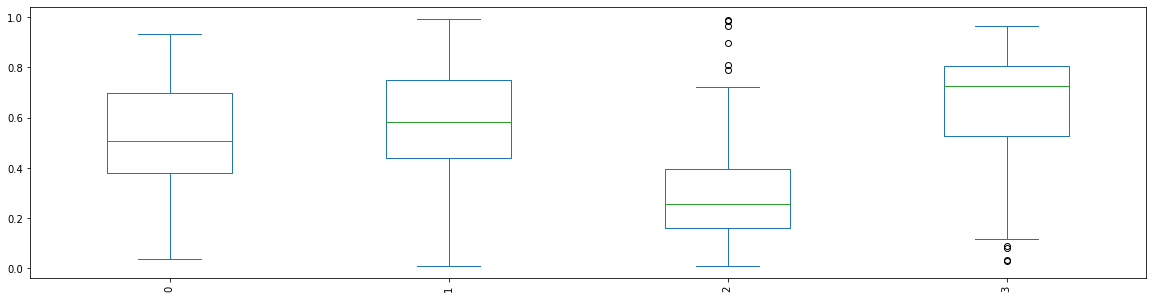

In [18]:
pd.DataFrame(X_validation_norm).plot.box(figsize=(20,5), rot=90)

In [19]:
print(len(train))
print(len(validation))
print(len(test))

961
274
137


In [20]:
def divideIntoBatches(x_list, y_list, batchLength):
  iterationNo = math.ceil(len(x_list)/batchLength)
  x_batches = []
  y_batches = []
  idx = 0
  for i in range(iterationNo):
    x_batch = []
    y_batch = []
    for j in range(batchLength):
      if(idx == len(x_list)):
        break;
      x_batch.append(x_list[idx])
      y_batch.append(y_list[idx])
      idx+=1
    # print(x_batch)
    x_batches.append(x_batch)
    y_batches.append(y_batch)
  return x_batches, y_batches

In [21]:
x_train_batches, y_train_batches = divideIntoBatches(X_train_norm, y_train, 100)
len(x_train_batches[0][0])

4

In [22]:
np.array(y_train_batches[9]).shape

(61,)

In [148]:


#X is [100, 5]
def forward_propagation(X, first_layer_Weights, first_layer_bias, second_layer_Weights, second_layer_bias):
    hidden_z = np.dot(X , first_layer_Weights) + first_layer_bias #100x4  -- 4x10 = 100x10 
    hidden_y = sigmoid(hidden_z)
    output_z = np.dot(hidden_y, second_layer_Weights ) + second_layer_bias #100x10 -- 10x1 = 100x1
    output_y = sigmoid(output_z)
    return hidden_z, hidden_y, output_z, output_y

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def compute_dE_dy(Y, Y_hat): #100x1
    return -(Y-Y_hat)

def compute_loss(Y, Y_hat):
    return (0.5) *(Y-Y_hat)**2 
  




In [149]:
def calculateValidationError(X, y,first_layer_W, first_layer_b, second_layer_W, second_layer_b):
    hidden_z, hidden_y, output_z, output_y = forward_propagation(X,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    return compute_loss(y, output_y)

In [150]:
# hidden_z, hidden_y, output_z, output_y = forward_propagation(x_train_batches[0],first_layer_W, first_layer_b, second_layer_W, second_layer_b)

In [151]:
# y = np.array(y_train_batches[0]).reshape((100,1))
# X = np.array(x_train_batches[0])
# dE_dy = compute_dE_dy(y, output_y)
# second_layer_W_gradient = np.matmul(hidden_y.reshape((10,100)), (dE_dy * output_y*(1-output_y))) #10,1
# second_layer_b_gradient = np.sum(dE_dy * output_y*(1-output_y))

# first_layer_W_gradient = np.matmul(X.reshape((4,100)),(np.matmul(second_layer_W, (dE_dy * output_y*(1-output_y)).reshape((1,100))).reshape((100,10)) * (hidden_y*(1-hidden_y))).reshape((100,10)))
# first_layer_b_gradient = np.sum(np.matmul(second_layer_W, ( dE_dy* output_y*(1-output_y)).reshape((1,100))).reshape((100,10)) * (hidden_y*(1-hidden_y)))


C:\Users\DELL\AppData\Local\Temp\ipykernel_29964\3500527743.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_batches2 = np.array(y_train_batches)
C:\Users\DELL\AppData\Local\Temp\ipykernel_29964\3500527743.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batches = np.array(x_train_batches).shape[0]


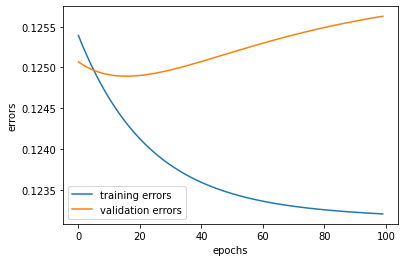

In [191]:
y_train_batches2 = np.array(y_train_batches)
eta = 0.01
epochs=100
batches = np.array(x_train_batches).shape[0]
random_state=1
random = np.random.RandomState(random_state)
first_layer_W = random.normal(loc=0.0, scale=0.1, size=(4, 10))
first_layer_b = random.normal(loc=10.0, scale=0.1, size=(1, 10))
second_layer_W =random.normal(loc=0.0, scale=0.1, size=(10, 1))
second_layer_b = random.normal(loc=10.0, scale=0.1, size=(1, 1))
training_errors = []
validation_errors = []
for epoch in range(epochs):
    batch_errors = []
    for batch in range (batches):
        y = np.array(y_train_batches2[batch])
        y = y.reshape((y.shape[0],1)) #convert y from vector to matrix (from (100,) to (100,1))
        X = np.array(x_train_batches[batch])
        batch_size = X.shape[0] #necessary because last batch is 61 samples not 100
        hidden_z, hidden_y, output_z, output_y = forward_propagation(X,first_layer_W, first_layer_b, second_layer_W, second_layer_b)

        error = compute_loss(y, output_y)
        batch_errors.append(np.mean(error))

        dE_dy = compute_dE_dy(y, output_y) #100x1
        # errors.append(np.mean(error))
        #dE/dy = -(y-y_hat)                reshape to be 10x100 (or(10,61)for last batch) for matmul    100x1
        second_layer_W_gradient = np.matmul(np.transpose(hidden_y), (dE_dy * output_y*(1-output_y))) #10,1
        #dE/dWi second layer =                  dz_out/dWi                          *  dE/dy_out *        dy_out/dz_out

        second_layer_b_gradient = np.sum(dE_dy * output_y*(1-output_y)) #1x1
        #dE/db second layer =          dE/dy_out *   dy_out/dz_out (sum over all training examples)
                                 #dE/dy *      dy_out/dz_out          reshaping from (100,1) to (1,100) to ease matmul                                 
        first_layer_W_gradient = np.transpose(dE_dy * output_y*(1-output_y))#.reshape((1,batch_size)) #1x100
        #                            * dz/dy_hidden (that is, the second_layer weights)
        
        first_layer_W_gradient = (np.matmul(second_layer_W, first_layer_W_gradient))#.reshape((batch_size,10)) #10x1 * 1x100 = 10x100 reshape to 100x10
        #                                               * dy_hidden/dz_hidden

        first_layer_W_gradient = (np.transpose(first_layer_W_gradient) *  (hidden_y*(1-hidden_y)))#.reshape((batch_size,10)) #100x10
        #                                  *dz_hidden/dW of first layer (that is, X)
        first_layer_W_gradient = np.matmul(np.transpose(X), first_layer_W_gradient)#4x100 * 100x10 = 4x10
        
        #same as w gradient but without last step dz_hidden/dw
        first_layer_b_gradient = np.sum(np.transpose(np.matmul(second_layer_W, (np.transpose(dE_dy * output_y*(1-output_y))))) * (hidden_y*(1-hidden_y)))

        second_layer_W -= (1/batch_size)* eta * second_layer_W_gradient
        second_layer_b -= (1/batch_size)*eta * second_layer_b_gradient
        first_layer_W -= (1/batch_size)*eta * first_layer_W_gradient
        first_layer_b -= (1/batch_size)*eta * first_layer_b_gradient
    training_errors.append(sum(batch_errors)/len(batch_errors))
    validation_error = calculateValidationError(X_validation_norm, y_validation,first_layer_W, first_layer_b, second_layer_W, second_layer_b)
    validation_errors.append(np.mean(validation_error))
    ##predict on validation data, calculate metrics 


#PLOTTING TRAINING ERROR
x1=range(0, epochs)
y1=training_errors
y2=validation_errors
plt.plot(x1, y1, label = "training errors")
plt.plot(x1, y2, label = "validation errors")
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('errors')
# giving a title to my graph
plt.title('')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [119]:
print(y_train_batches[0][3])
hidden_z, hidden_y, output_z, output_y = forward_propagation(x_train_batches[0][3],first_layer_W, first_layer_b, second_layer_W, second_layer_b)

print(output_y)

0.0
[[0.44615488]]


In [158]:
x = np.array([[1,2,3],[4,5,6]])
x


array([[1, 2, 3],
       [4, 5, 6]])

In [157]:
x.reshape((3,2))

array([[1, 2],
       [3, 4],
       [5, 6]])

In [159]:
np.transpose(x)

array([[1, 4],
       [2, 5],
       [3, 6]])